<a href="https://colab.research.google.com/github/hello-ram/transferLearning_pneumonia/blob/master/Transfer_Learning_Xray_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 00 Setup 

In [0]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxx"

seed(100)
set_random_seed(100)

## 00.1 Helper Functions

In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# 01 Download Data

In [7]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

100% 2.29G/2.29G [00:14<00:00, 179MB/s]
100% 2.29G/2.29G [00:14<00:00, 171MB/s]
CPU times: user 211 ms, sys: 50.5 ms, total: 262 ms
Wall time: 15.4 s


In [8]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [0]:
os.remove("chest-xray-pneumonia.zip") # clean up directory a bit

# 02 Explore Data

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #directories for training

test_dir  = "chest_xray/val/" #directory for final model scoring


In [13]:
search_dir(type="pneumonia", num=10)

person67_bacteria_332.jpeg
person419_virus_861.jpeg
person515_bacteria_2189.jpeg
person1471_bacteria_3831.jpeg
person1082_virus_1794.jpeg
person922_bacteria_2847.jpeg
person23_bacteria_84.jpeg
person600_bacteria_2456.jpeg
person1021_virus_1711.jpeg
person1746_bacteria_4585.jpeg


In [14]:
search_dir(type="normal", num=10)

NORMAL2-IM-0582-0001.jpeg
NORMAL2-IM-1371-0001.jpeg
IM-0306-0001.jpeg
NORMAL2-IM-1314-0001.jpeg
IM-0240-0001.jpeg
IM-0511-0001-0002.jpeg
NORMAL2-IM-0526-0001.jpeg
NORMAL2-IM-1277-0001-0002.jpeg
IM-0286-0001.jpeg
IM-0311-0001.jpeg


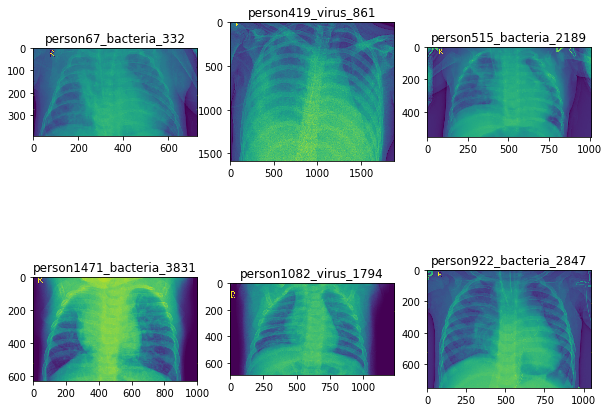

In [15]:
plot_images(type="pneumonia", num=6)

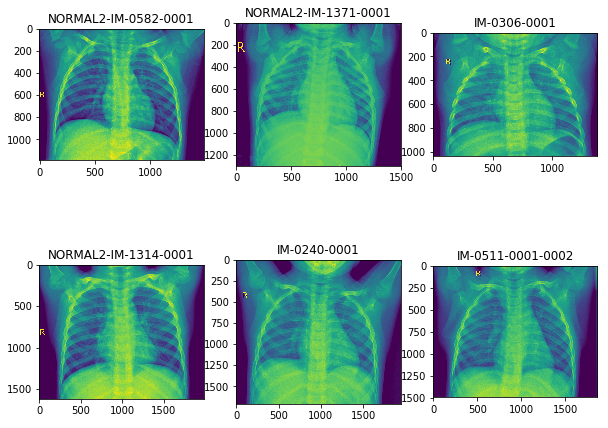

In [16]:
plot_images(type="normal", num=6)

# 03 Modeling

## 03.01 Pre-Trained Model w/o Transfer Learning

In [17]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image


Using TensorFlow backend.


In [18]:
pre_model = InceptionV3(weights='imagenet')










96116736/96112376 [==============================] - 1s 0us/step


In [19]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


## 03.2 Data Preparation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract 

In [23]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical") 

Found 5216 images belonging to 2 classes.


In [24]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [25]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


#03.03 Train Model

In [0]:
import keras


In [27]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model



87916544/87910968 [==============================] - 1s 0us/step


In [28]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])


In [29]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 105s 3s/step - loss: 0.5314 - acc: 0.8278 - val_loss: 2.8625 - val_acc: 0.6250
Epoch 2/5
32/32 [==============================] - 92s 3s/step - loss: 0.2606 - acc: 0.9045 - val_loss: 1.1796 - val_acc: 0.7196
Epoch 3/5
32/32 [==============================] - 95s 3s/step - loss: 0.2209 - acc: 0.9120 - val_loss: 1.2592 - val_acc: 0.6955
Epoch 4/5
32/32 [==============================] - 93s 3s/step - loss: 0.2152 - acc: 0.9128 - val_loss: 1.3723 - val_acc: 0.7131
Epoch 5/5
32/32 [==============================] - 93s 3s/step - loss: 0.2146 - acc: 0.9164 - val_loss: 2.0167 - val_acc: 0.6955


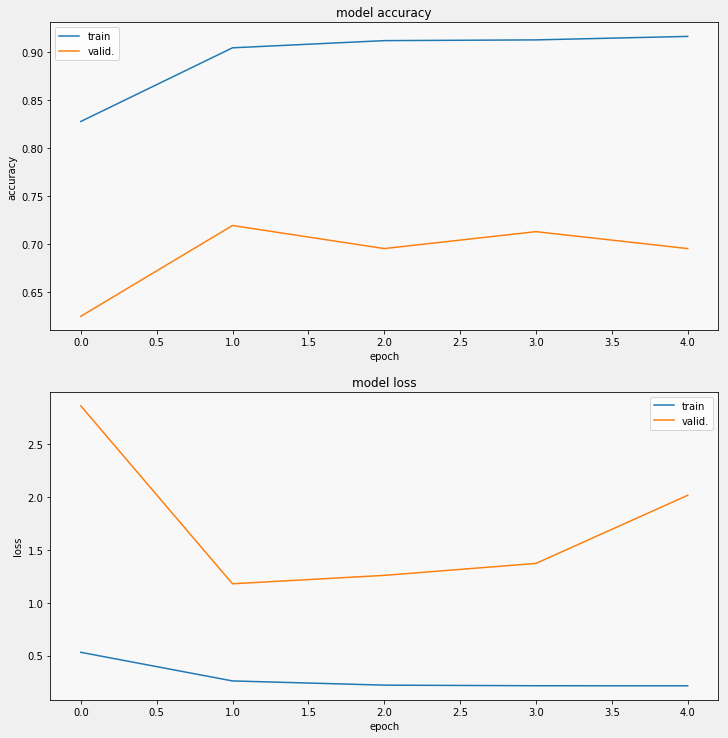

In [30]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [31]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 2.2975365270277743
Accuracy: 0.625


In [32]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [33]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])

In [34]:
#Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

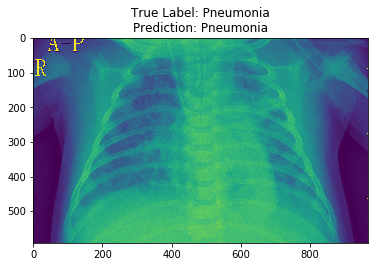

In [36]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)



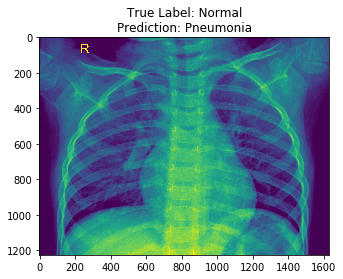

In [38]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)